## Amini Solution Architect EDA notebook

### Task
**Create a comprehensive climate risk profile for Admin 3 levels for one Admin 1 level (Eigeyo Marakwet County) in Kenya**
- To develop an integrated hazard and exposure risk
- To develop climate profiles for the different admin 3 levels
- To provide recommendations for risk mitigation

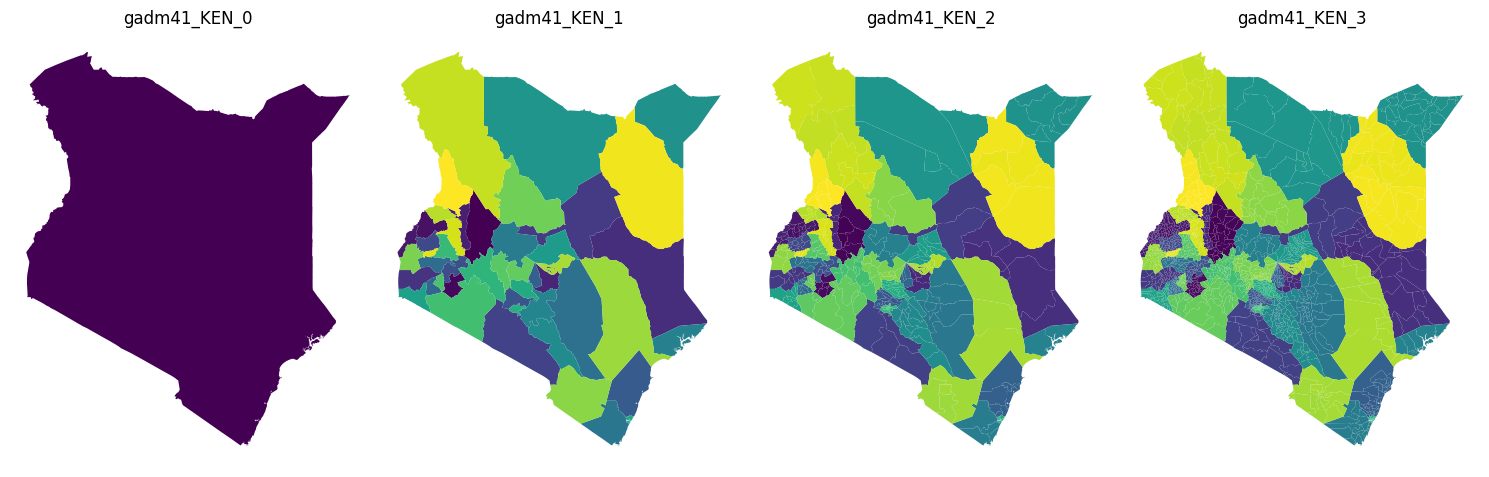

In [1]:
import os
from datetime import datetime
from glob import glob
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from dateutil.relativedelta import relativedelta
from rasterio.mask import mask
from rasterio.plot import show

%matplotlib inline

data_raw = Path('../data/01_raw')

fig, ax = plt.subplots(1, 4, figsize=(15, 7))

for i, file in enumerate(sorted(glob(f"{data_raw}/vector/gadm41_KEN_shp/*.shp"))):
    gdf = gpd.read_file(file)
    gdf.plot(ax=ax[i], cmap='viridis')
    ax[i].set_title(Path(file).stem)
    ax[i].set_axis_off()

plt.tight_layout()
plt.show()


In [2]:
# Init GEE
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='amini-sa')

<Axes: >

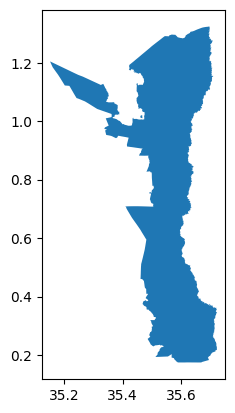

In [3]:
# Get Kenya boundary
Kenya_gpd = gpd.read_file(f"{data_raw}/vector/gadm41_KEN_shp/gadm41_KEN_1.shp").to_crs(epsg=4326)
# Get Elgeyo Marakwet County boundary
EMC1_gpd = Kenya_gpd[Kenya_gpd['NAME_1'] == 'Elgeyo-Marakwet']
EMC1_gpd.plot()

In [4]:
# Merging multiple EMC boundaries into one
ee_EMC_bound = geemap.gdf_to_ee(EMC1_gpd)
ee_EMC_bound.geometry()

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection",
          "arguments": {
            "features": {
              "arrayValue": {
                "values": [
                  {
                    "functionInvocationValue": {
                      "functionName": "Feature",
                      "arguments": {
                        "geometry": {
                          "functionInvocationValue": {
                            "functionName": "GeometryConstructors.MultiPolygon",
                            "arguments": {
                              "coordinates": {
                                "constantValue": [
                                  [
                                    [
                                      [
                                        35.52715682900009,
                                        0.216740906000098
                                      ],
                                      [
                                        35.526142121000134,
                                        0.218345613000054
                                      ],
                                      [
                                        35.53067779600019,
                                        0.224946976000126
                                      ],
                                      [
                                        35.534748077000074,
                                        0.227336422000121
                                      ],
                                      [
                                        35.5370025630001,
                                        0.226674320000029
                                      ],
                                      [
                                        35.53702926600005,
                                        0.226771221000149
                                      ],
                                      [
                                        35.53713989200014,
                                        0.227165594000041
                                      ],
                                      [
                                        35.53736114500009,
                                        0.227498413000092
                                      ],
                                      [
                                        35.537387848000094,
                                        0.227522553000142
                                      ],
                                      [
                                        35.53742599500009,
                                        0.227557064000052
                                      ],
                                      [
                                        35.53747558500015,
                                        0.227598802000159
                                      ],
                                      [
                                        35.53772735600012,
                                        0.227822408000179
                                      ],
                                      [
                                        35.53815078700006,
                                        0.228024915000162
                                      ],
                                      [
                                        35.538692474000186,
                                        0.228102430999968
                                      ],
                                      [
                                        35.53911972000003,
                                        0.228255167000043
                                      ],
                                      [
                                        35.539283752000074,
                                        0.228313238000112
          

### Drought Hazard Exposure Raw Data
- Combination of SMAP L3 and SPEI from GEE

In [5]:
## 48 months average SMAP
date_now = datetime.now().date().isoformat()
date_48 = (datetime.now() - relativedelta(months=48)).date().isoformat()

# Get raster
SMAP_mean = (ee.ImageCollection("NASA/SMAP/SPL3SMP_E/006")
          .filterDate(date_48, date_now)
          .filterBounds(ee_EMC_bound.geometry())
          .select('soil_moisture_am')
          .mean())

SPEI_mean = (ee.ImageCollection("CSIC/SPEI/2_10")
          .filterDate(date_48, date_now)
          .filterBounds(ee_EMC_bound.geometry())
          .select('SPEI_48_month')
          .mean())

os.makedirs(f"{data_raw}/raster", exist_ok=True)
geemap.ee_export_image(SMAP_mean, region=ee_EMC_bound.geometry(), filename=f"{data_raw}/raster/SMAP_mean.tif")
geemap.ee_export_image(SPEI_mean, region=ee_EMC_bound.geometry(), filename=f"{data_raw}/raster/SPEI_mean.tif")

Generating URL ...
Please wait ...
Data downloaded to /home/chris/mnt1/Proj/amini-sa/data/01_raw/raster/SMAP_mean.tif
Generating URL ...
Please wait ...
Data downloaded to /home/chris/mnt1/Proj/amini-sa/data/01_raw/raster/SPEI_mean.tif


Text(0.5, 1.0, 'SPEI')

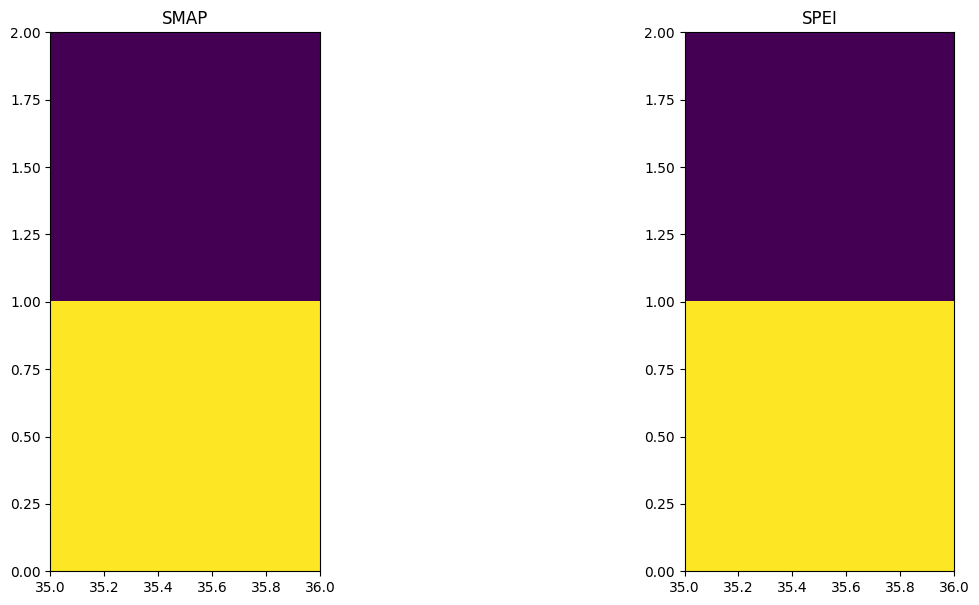

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

with rio.open(f"{data_raw}/raster/SMAP_mean.tif") as src:
    SMAP_mean_arr = src.read(1)
    SMAP_mean_meta = src.meta

with rio.open(f"{data_raw}/raster/SPEI_mean.tif") as src:
    SPEI_mean_arr = src.read(1)
    SPEI_mean_meta = src.meta

show(SMAP_mean_arr, ax=ax[0], transform=SMAP_mean_meta['transform'])
show(SPEI_mean_arr, ax=ax[1], transform=SPEI_mean_meta['transform'])

ax[0].set_title('SMAP')
ax[1].set_title('SPEI')

### Flood Hazard Exposure Raw Data
- Using WRI Aqueduct Floods Hazard Maps V2

In [7]:
GFH_mean = (ee.ImageCollection("JRC/CEMS_GLOFAS/FloodHazard/v1")
          .filterDate(date_48, date_now)
          .filterBounds(ee_EMC_bound.geometry())
          .select('depth')
          .mean())

geemap.ee_export_image(GFH_mean, region=ee_EMC_bound.geometry(), filename=f"{data_raw}/raster/GFH_mean.tif")

Generating URL ...
Please wait ...
Data downloaded to /home/chris/mnt1/Proj/amini-sa/data/01_raw/raster/GFH_mean.tif


<Axes: >

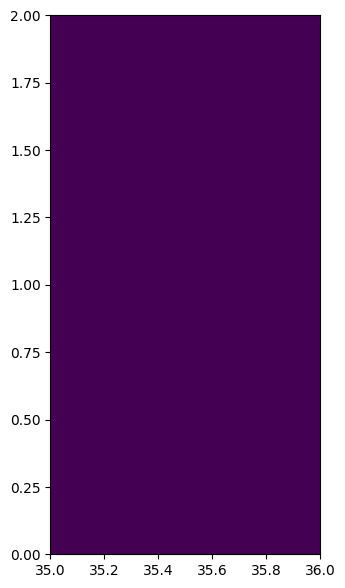

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

with rio.open(f"{data_raw}/raster/GFH_mean.tif") as src:
    GFH_mean_arr = src.read(1)
    GFH_mean_meta = src.meta

show(GFH_mean_arr, ax=ax, transform=GFH_mean_meta['transform'])

### There seems to be a problem with GEE based global products where the extent is too large and the resolution is too low
I will now attempt to get higher resolution data from Humanitarian Data Exchange

### IGAD Region - Monthly Combined Drough Indicator 2024-25
https://data.humdata.org/dataset/igad-region-monthly-combined-drought-indicator-cdi-2024
https://data.humdata.org/dataset/igad-region-monthly-combined-drought-indicator-cdi-2025

In [9]:
# Create new raster that combines the 2024 and 2025 data
all_cdi_arrays = []
dates = []
file_transform = None
file_meta = None

data_intermediate = Path('../data/02_intermediate')

# Loop through all CDI files
for cdi_file in sorted(glob(f"{data_raw}/raster/IGAD_CDI/*.tiff")):
    with rio.open(cdi_file, "r") as src:
        file_meta, file_transform = src.meta.copy(), src.transform
        # Mask the raster to EMC boundary
        masked_data, out_transform = mask(src, EMC1_gpd.geometry, crop=True, nodata=np.nan)
        # Add masked data to our collection
        all_cdi_arrays.append(masked_data[0])

# There's 11 months of data, assert that it is true before calculation
if all_cdi_arrays and len(all_cdi_arrays) == 11:
    cdi_stack = np.stack(all_cdi_arrays)

    cdi_mean = np.nanmean(cdi_stack, axis=0)

    file_meta.update({
        'driver': 'GTiff',
        'height': cdi_mean.shape[0],
        'width': cdi_mean.shape[1],
        'transform': file_transform,
        'nodata': np.nan
    })

    # Save the mean CDI
    os.makedirs(f"{data_intermediate}/raster", exist_ok=True)
    output_path = f"{data_intermediate}/raster/EMC_CDI_mean.tif"
    with rio.open(output_path, 'w', **file_meta) as dst:
        dst.write(cdi_mean, 1)

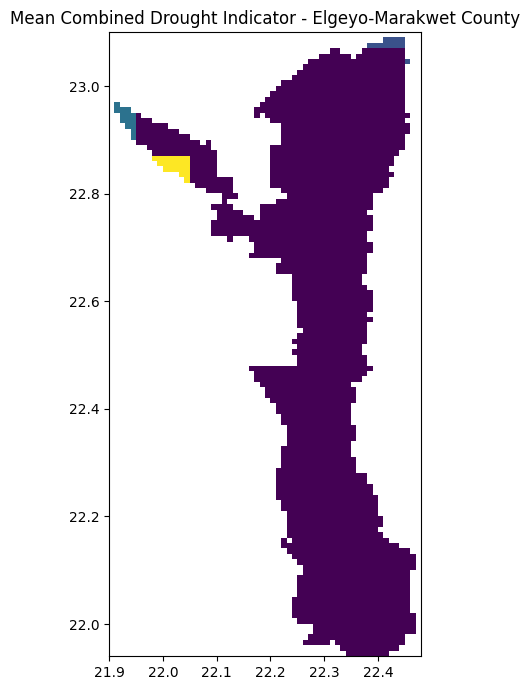

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

with rio.open(f"{data_intermediate}/raster/EMC_CDI_mean.tif", "r") as src:
    EMC_drought, out_transform = src.read(1), src.transform

    # Show the masked data with the transform (not trying to access as dictionary)
    CDI_EMC = show(EMC_drought, ax=ax, transform=out_transform)
    #cbar = fig.colorbar(CDI_EMC, ax=ax, orientation='vertical')
    ax.set_title('Mean Combined Drought Indicator - Elgeyo-Marakwet County')

plt.tight_layout()
plt.show()

### Drought Hazard Profile for gadm level 3
- Compute spatial statistics for each gadm level 3 regions
